In [1]:
from jwst.pipeline import Detector1Pipeline, Image2Pipeline, Image3Pipeline
import jwst.associations
from jwst.associations.lib.rules_level3_base import DMS_Level3_Base

from glob import glob
import astropy.io.fits as fits

import os
import astroquery
from astroquery.mast import Observations
from crds import client
import pandas as pd

from astropy.table import Table
from astropy.wcs import WCS
import numpy as np

2024-02-06 10:38:07,774 - stpipe - WARNING - /tmp/ipykernel_2420/2463252082.py:12: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd



In [2]:
os.environ['CRDS_PATH'] = '../CRDS/crds_cache/'
os.environ["CRDS_SERVER_URL"] = "https://jwst-crds.stsci.edu"
os.environ["CRDS_CONTEXT"] = "jwst_1188.pmap"

In [3]:
client.set_crds_server("https://jwst-crds.stsci.edu")

In [4]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

# figure sizes and resolutions
rcParams['figure.figsize'] = [11,8]
rcParams['figure.dpi'] = 80
rcParams['savefig.dpi'] = 80

In [5]:
import jwst
print(jwst.__version__)

1.12.5


# **Data**

In [ ]:
mast_dir = 'mast:jwst/product' # Download from MAST
data_dir = '../data/stage1/'  # save downloaded data
os.makedirs(data_dir, exist_ok=True)

ext = 'rate'
# JWST images to be analyzed
image_files = []

for i in range(1,5):
    for j in range(1,5):
        for k in [3,4]:
            image_files.append( f"jw0178300400{k}_02101_0000{i}_nrcb{j}_{ext}.fits")

for image_file in image_files:
    # Download file (if not already downloaded)
    mast_path  = os.path.join(mast_dir, image_file)
    local_path = os.path.join(data_dir, image_file)
    Observations.download_file(mast_path, local_path=local_path)

# **Stage 2**

In [12]:
def stage2(filename, output_dir):
    # Instantiate the pipeline
    img2 = Image2Pipeline()
    # Specify where the output should go
    img2.output_dir = output_dir
    # Save the final resulting _rate.fits files
    img2.save_results = True
    # Run the pipeline on an input list of files
    img2(filename)

In [33]:
rate_files = glob(os.path.join("../data/stage1/", '*4003*nrcb4_rate.fits'))
rate_files += glob(os.path.join("../data/stage1/", '*4004*nrcb4_rate.fits'))

In [34]:
len(rate_files)

8

In [ ]:
for f in rate_files:
    stage2(f,"../data/stage2/")

# **Stage 3**

In [16]:
def stage3(filename, output_dir):
    # Instantiate the pipeline
    img3 = Image3Pipeline()
    # Specify where the output should go
    img3.output_dir = output_dir
    # Save the final resulting _rate.fits files
    img3.save_results = True
    # Run the pipeline on an input list of files
    img3(filename)

In [13]:
cal_files = glob(os.path.join("../data/stage2/", '*cal.fits'))

In [ ]:
for f in cal_files:
    stage3(f,"../data/stage3/")
    break

# **DOLPHOT**

In [ ]:
os.system(f"nircammask ../data/stage2/f200w_i2d.fits")

In [38]:
cal_files = glob(os.path.join("../data/stage2/", '*4003*nrcb4_cal.fits'))
cal_files += glob(os.path.join("../data/stage2/", '*4004*nrcb4_cal.fits'))


In [39]:
cal_files

['../data/stage2/jw01783004003_02101_00001_nrcb4_cal.fits',
 '../data/stage2/jw01783004003_02101_00002_nrcb4_cal.fits',
 '../data/stage2/jw01783004003_02101_00003_nrcb4_cal.fits',
 '../data/stage2/jw01783004003_02101_00004_nrcb4_cal.fits',
 '../data/stage2/jw01783004004_02101_00001_nrcb4_cal.fits',
 '../data/stage2/jw01783004004_02101_00002_nrcb4_cal.fits',
 '../data/stage2/jw01783004004_02101_00003_nrcb4_cal.fits',
 '../data/stage2/jw01783004004_02101_00004_nrcb4_cal.fits']

In [40]:
exps = []
for i,f in enumerate(cal_files):
    out_dir = f.split('_')[-2] + f.split('/')[-1].split('_')[0][-4:] + f.split('_')[-3]
    exps.append(out_dir)
    if not os.path.exists(f'../data/stage2/{out_dir}'):
        os.mkdir(f'../data/stage2/{out_dir}')

    os.system(f"cp {f} ../data/stage2/{out_dir}/data.fits")

In [41]:
for f in exps:
    os.system(f"nircammask ../data/stage2/{f}/data.fits")
    os.system(f"calcsky ../data/stage2/{f}/data 10 25 2 2.25 2.00")

Reading FITS file ../data/stage2/nrcb4400300001/data.fits
Reading IMAGE extension: 2048x2048
Reading IMAGE extension: 2048x2048
Reading IMAGE extension: 2048x2048
Reading IMAGE extension: 2048x2048
Reading IMAGE extension: 2048x2048
Reading IMAGE extension: 2048x2048
Reading IMAGE extension: 2048x2048
Reading BINTABLE extension: 25131
Writing FITS file ../data/stage2/nrcb4400300001/data.fits
Writing IMAGE extension: 2048x2048
Reading FITS file ../data/stage2/nrcb4400300001/data.fits
Reading IMAGE extension: 2048x2048
  BAD=-1.00 SAT=65535.00
  BAD=-322.50 SAT=445477.38
......................................................................
Writing FITS file ../data/stage2/nrcb4400300001/data.sky.fits
Writing IMAGE extension: 2048x2048
Reading FITS file ../data/stage2/nrcb4400300002/data.fits
Reading IMAGE extension: 2048x2048
Reading IMAGE extension: 2048x2048
Reading IMAGE extension: 2048x2048
Reading IMAGE extension: 2048x2048
Reading IMAGE extension: 2048x2048
Reading IMAGE extension

In [42]:
with open("../params/nircam_dolphot_f115w.param") as f:
            dat = f.readlines()
dat[0] = f'Nimg = {len(exps)}                #number of images (int)\n'
dat[4] = 'img0_file = ../data/stage2/f115w_i2d\n'

for i,f in enumerate(exps):
    dat[5+i] = f'img{i+1}_file = ../data/stage2/{f}/data           #image {i+1}\n'

with open("../params/nircam_dolphot_f115w.param", 'w', encoding='utf-8') as f:
    f.writelines(dat)

In [ ]:
os.system(f"dolphot ../data/stage2/output_f115w/out -p../params/nircam_dolphot_f115w.param")

Reading FITS file ../data/stage2/nrcb4400300001/data.fits
Reading FITS file ../data/stage2/nrcb4400300002/data.fits
Reading FITS file ../data/stage2/nrcb4400300003/data.fits
Reading FITS file ../data/stage2/nrcb4400300004/data.fits
Reading FITS file ../data/stage2/nrcb4400400001/data.fits
Reading FITS file ../data/stage2/nrcb4400400002/data.fits
Reading FITS file ../data/stage2/nrcb4400400003/data.fits
Reading FITS file ../data/stage2/nrcb4400400004/data.fits
Reading FITS file ../data/stage2/f115w_i2d.fits
Reading IMAGE extension: 2048x2048
  GAIN=2.03 EXP=365s NOISE=12.52 BAD=-322.50 SAT=445477.38
Reading IMAGE extension: 2048x2048
  GAIN=2.03 EXP=365s NOISE=12.52 BAD=-393.09 SAT=450657.56
Reading IMAGE extension: 2048x2048
  GAIN=2.03 EXP=365s NOISE=12.52 BAD=-682.65 SAT=443899.88
Reading IMAGE extension: 2048x2048
  GAIN=2.03 EXP=365s NOISE=12.52 BAD=-289.08 SAT=456072.31
Reading IMAGE extension: 2048x2048
  GAIN=2.03 EXP=365s NOISE=12.52 BAD=-238.56 SAT=450927.81
Reading IMAGE exte

In [ ]:
det= 'nrcb4'
os.system(f"python ../scripts/to_table.py --o F115W_photometry_{det} --n {len(exps)} --f ../data/stage2/output_f115w/out")
    
phot_table = Table.read(f"../data/stage2/output_f115w/F115W_photometry_{det}.fits")
phot_table.rename_columns(['mag_vega'],[f'mag_vega_F115W'])

hdu = fits.open(f"../data/stage2/F115W_i2d.fits")[1]

wcs = WCS(hdu.header)
positions = np.transpose([phot_table['x'] - 0.5, phot_table['y']-0.5])

coords = np.array(wcs.pixel_to_world_values(positions))

phot_table['ra']  = coords[:,0]
phot_table['dec'] = coords[:,1]

phot_table1 = phot_table[ (phot_table['sharpness']**2   <= 0.01) &
                            (phot_table['obj_crowd']    <=  0.5) &
                            (phot_table['flags']        <=    2) &
                            (phot_table['type']         <=    2)]

phot_table2 = phot_table[ ~((phot_table['sharpness']**2 <= 0.01) &
                            (phot_table['obj_crowd']    <=  0.5) &
                            (phot_table['flags']        <=    2) &
                            (phot_table['type']         <=    2))]
print('NIRCAM SHORT')
phot_table1.write(f'../data/stage2/output_f115w/F115W_photometry_{det}_filt.fits', overwrite=True)

In [10]:
phot_table = Table.read('../data/stage2/output_f115w/F115W_photometry_nrca1a2_filt.fits')

(0.0, 1.0)

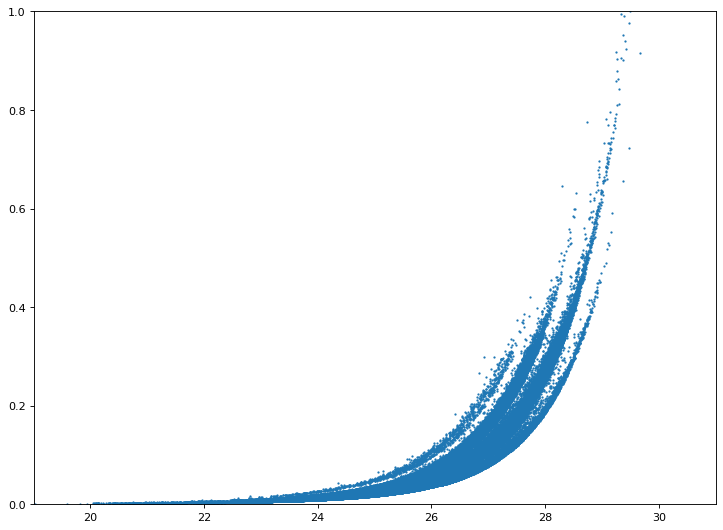

In [12]:
x = phot_table['mag_vega_F115W']
y = phot_table['mag_err']

plt.scatter(x,y,s=1)

plt.xlim(19,31)

plt.ylim(0,1)

In [12]:
len(phot_table)

104594